In [ ]:
#### 
# Created by Ewerton Lopes
# Politecnico di Milano, December, 2016.

In [1]:
from __future__ import division
%matplotlib inline
import csv
import sys
import os
import traceback
import json
import numpy as np
import pandas as pd
from tabulate import tabulate
from pandas.tools.plotting import lag_plot, autocorrelation_plot
from matplotlib import pyplot as plt
from collections import defaultdict, Counter
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
import scipy.fftpack as fft
from helper_functions import getListOfFiles, getCSV, getStatistics

## Dataset features:

**Reference:** </br>
1. Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

The features selected for this dataset come from the accelerometer and gyroscope 3-axial raw signals tAcc-XYZ and tGyro-XYZ. That signal was taken using the <a href=http://playground.arduino.cc/Main/MPU-6050> InvenSense MPU-6050 </a> sensor, which contains a MEMS accelerometer and a MEMS gyro in a single chip. The sensor possess a 16-bits analog to digital conversion hardware for each channel. Therefor it captures the x, y, and z channel at the same time. The sensor was used with the I2C-bus to interface with an Arduino attached to the player.  We also use a Microsoft Kinect 2 sensor in order to get 3 additional features: Contraction Index (CI), distance, proximity. This last feature is a normalized - [0,1] interval - version of distance. Thus, they shall be used in mutually exclusion. The normalization is done by limiting the distance to 4.5 meters, the known stable limit of the sensor. So, the player has a greater proximity value when it is seen close to the robot. The value tends to zero otherwise. Ideally, the CI feature correspond to how open-wide (in terms of legs and arms) the player is.

Here, we organize the feature similar to <a href=https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones> Anguita at al.</a>. The time domain signals are (prefix 't' to denote time) were captured at a about rate of 48 Hz for the MPU-6050 based data. <font color='red'>Then they were filtered using a median filter and a 3rd order low pass Butterworth filter with a corner frequency of 20 Hz to remove noise. Similarly, the acceleration signal was then separated into body and gravity acceleration signals (tBodyAcc-XYZ and tGravityAcc-XYZ) using another low pass Butterworth filter with a corner frequency of 0.3 Hz.

Subsequently, the body linear acceleration and angular velocity were derived in time to obtain Jerk signals
(tBodyAccJerk-XYZ and tBodyGyroJerk-XYZ). Also the magnitude of these three-dimensional signals were calculated
using the Euclidean norm (tBodyAccMag, tGravityAccMag, tBodyAccJerkMag, tBodyGyroMag, tBodyGyroJerkMag).

Finally a Fast Fourier Transform (FFT) was applied to some of these signals producing fBodyAcc-XYZ,
fBodyAccJerk-XYZ, fBodyGyro-XYZ, fBodyAccJerkMag, fBodyGyroMag, fBodyGyroJerkMag.
(Note the 'f' to indicate frequency domain signals).

These signals were used to estimate variables of the feature vector for each pattern:  
'-XYZ' is used to denote 3-axial signals in the X, Y and Z directions.

tBodyAcc-XYZ
tGravityAcc-XYZ
tBodyAccJerk-XYZ
tBodyGyro-XYZ
tBodyGyroJerk-XYZ
tBodyAccMag
tGravityAccMag
tBodyAccJerkMag
tBodyGyroMag
tBodyGyroJerkMag
fBodyAcc-XYZ
fBodyAccJerk-XYZ
fBodyGyro-XYZ
fBodyAccMag
fBodyAccJerkMag
fBodyGyroMag
fBodyGyroJerkMag

The set of variables that were estimated from these signals are: 

mean(): Mean value
std(): Standard deviation
mad(): Median absolute deviation 
max(): Largest value in array
min(): Smallest value in array
sma(): Signal magnitude area
energy(): Energy measure. Sum of the squares divided by the number of values. 
iqr(): Interquartile range 
entropy(): Signal entropy
arCoeff(): Autorregresion coefficients with Burg order equal to 4
correlation(): correlation coefficient between two signals
maxInds(): index of the frequency component with largest magnitude
meanFreq(): Weighted average of the frequency components to obtain a mean frequency
skewness(): skewness of the frequency domain signal 
kurtosis(): kurtosis of the frequency domain signal 
bandsEnergy(): Energy of a frequency interval within the 64 bins of the FFT of each window.
angle(): Angle between to vectors.

Additional vectors obtained by averaging the signals in a signal window sample. These are used on the angle() variable:

gravityMean
tBodyAccMean
tBodyAccJerkMean
tBodyGyroMean
tBodyGyroJerkMean

The complete list of variables of each feature vector is available in 'features.txt' </font>

Let's load the csv files, that together comprise the our dataset, from the `.data` directory:

In [2]:
csv_dir = "./data"
files = getListOfFiles(csv_dir, ".csv")
print ">> {} CSV Files found:\n".format(len(files))
print json.dumps(files)

>> 34 CSV Files found:

["_2016-11-23-18-49-13_exp1_Player.csv", "_2016-11-23-18-49-13_exp2_Player.csv", "_2016-11-23-18-49-13_exp3_Player.csv", "_2016-11-23-18-49-13_exp4_Player.csv", "_2016-11-23-18-49-13_exp5_Player.csv", "_2016-11-24-15-43-37_exp1d_Player.csv", "_2016-11-24-15-43-37_exp2d_Player.csv", "_2016-11-24-15-43-37_exp3d_Player.csv", "_2016-11-24-15-43-37_exp4d_Player.csv", "_2016-11-24-15-43-37_exp5d_Player.csv", "_2016-11-24-15-43-37_exp6d_Player.csv", "_2016-11-24-16-23-29_expa_Player.csv", "_2016-11-24-16-23-29_expb_Player.csv", "_2016-11-24-16-23-29_expc_Player.csv", "_2016-11-24-16-23-29_expd_Player.csv", "_2016-11-24-16-48-48_exp1d_Player.csv", "_2016-11-24-16-48-48_exp2d_Player.csv", "_2016-11-24-16-48-48_exp3d_Player.csv", "_2016-11-24-17-15-38_expa_Player.csv", "_2016-11-24-17-15-38_expb_Player.csv", "_2016-11-24-17-15-38_expc_Player.csv", "_2016-11-24-17-40-06_expb_Player.csv", "_2016-11-26-15-42-51_exp1d_Player.csv", "_2016-11-26-16-05-47_exp1d_Player.csv", "_20

## Data summary

In [ ]:
# Get details about the data stored on the csv files.
%run data_summary.py -f data

## Plot functions:

In [3]:
def pdf(data,suptitle="PDF fitting", headers="", normalize_data=False):
    """Plot the probability density function.
    Args:
        data (list: pd.Series): the list of data to be used.
        headers (list: str)   : list of titles for the plots
        normalize_data : normalize data prior to fit the pdf.
    """

    grid_side_size = int(round(np.sqrt(len(data))))
    #fig = plt.figure(figsize=(11,7))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))
    
    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                break
                
            #normalize vector
            if normalize_data:
                n_data = data[count]/data[count].sum()
            else:
                n_data = data[count]
                
            # Fit a normal distribution to the data:
            mu, sigma = norm.fit(n_data)
            
            if headers == "":
                row[j].set_title("{}-Fit. mu={:.2f},  std={:.2f}".format(count, mu, sigma), fontsize=8)
            else:
                row[j].set_title("Fit for {}. mu={:.2f},  std={:.2f}".format(headers[count], mu, sigma), fontsize=8)
            
            # Using the  Freedman-Diaconis rule for getting the number of bins
            bin_size = 2 * iqr(n_data) * len(n_data) ** (-1 / 3)
            bins = int(round((max(n_data) - min(n_data)) / bin_size))

            # Plot the histogram.
            bin_value, bin_edges, p = row[j].hist(n_data, bins=bins, normed=True, alpha=0.6, color='g')
            
            # Normalizing heights
            #debug = 0
            #for i, item in enumerate(p):
            #    debug += (bin_value[i] / sum(bin_value*np.diff(bin_edges)))
            #    item.set = bin_value[i]/ sum(bin_value*np.diff(bin_edges))
            #print debug

            # Plot the PDF.
            xmin, xmax = row[j].get_xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mu, sigma)
            row[j].plot(x, p, 'k', linewidth=2, color='r')
            count += 1

    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.draw()

def gridOfPlots(data, columnToPlot, suptitle="PDF fitting"):
    """Plots the data in a grid of plots.
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    
    grid_side_size = int(round(np.sqrt(len(data))))
    fig, axes = plt.subplots(grid_side_size, grid_side_size, figsize=(18,12))

    count = 0
    for i, row in enumerate(axes):
        for j in range(grid_side_size):
            if count >= len(data):
                break
            row[j].set_title("Windows-{}".format(count), fontsize=8, fontweight="bold")
            row[j].plot(data[count][columnToPlot].dropna())
            count += 1

    fig.suptitle(suptitle, fontsize=21)
    fig.subplots_adjust(hspace=0.5, wspace= 0.4)
    plt.draw()

def gridOfLagPlots(data, columnToPlot, suptitle="Plot"):
    """Plots a grid of plots corresponding to a lag-one time series 
    graph for the given column.
    
    The 'abscissa' correspond to the column value at time t. The 'ordinate' correspond
    to the column value at time t-1. Hence the name 'lag-one' time series plot.
    
    Args:
        data (list): the list of data to be used.
        title (str): grid title.
        columnToPlot: the column in the data to be plotted.
    """
    grid_side_size = int(round(np.sqrt(len(data))))
    plt.figure(figsize=(18,12))

    count = 0
    for i in range(grid_side_size):
        for j in range(grid_side_size):
            if count >= len(data):
                break
            plt.subplot(grid_side_size,grid_side_size,count+1)
            lag_plot(data[count][columnToPlot].dropna())
            plt.title("Windows-{}".format(count))
            count += 1


    plt.suptitle(suptitle, fontsize=21)
    plt.subplots_adjust(hspace=0.5, wspace= 0.4)
    plt.draw()

# EXPLORATORY DATA ANALYSIS

Now, we define a dictionary containing a remap of the name of the features. This is to easy visualization since ros feature names may be very long and also allow quick decoupled modifications (just edit the variable locally). Also, from it we define a ignore list containing the names we do not want to consider for the analysis. That is done by setting to the ignore list all dictionary keys with empty values. **Here we assume the names are consistent feature name w.r.t. the `csv` data. Otherwise, a `ValueError` exception is likely to be thrown!**

In [4]:
# variable for storing the loaded feature names.
feature_name_map = {
  "time" : "time",
  "Control": "control",
  "High_level": "high_level",
  "Expectation": "expectation",
  "Activity": "activity",
  "/kinect_features/.ci": "ci",
  "/kinect_features/.distance": "distance",
  "/kinect_features/.proximity": "proximity",
  "robogame/imu_state.gyro.x": "gyroX",
  "robogame/imu_state.gyro.y": "gyroY",
  "robogame/imu_state.gyro.z": "gyroZ",
  "robogame/imu_state.linear_acc.x": "accX",
  "robogame/imu_state.linear_acc.y": "accY",
  "robogame/imu_state.linear_acc.z": "accZ"
}

ignore_col_list = [k for k,v in feature_name_map.items() if v is ""]
print "List of ignored topics: {}".format(ignore_col_list)

List of ignored topics: []


## Load data

We begin the analysis using only one file. Of course, once it is completed, we extend the analysis for the other files in the list.

In [5]:
csv_filename = files[0]  # get only the fist loaded csv file.
csv_data = None          # the variable where the loaded csv data is stored.
num_windows = 0          # the number of windows loaded.
wFrames = []             # the list of windows data. Each element is a pandas dataframe 
                         #  corresponding to the windows. The list is of size 'num_windows'.

print 'Processing: "{}"'.format(csv_filename)

# load the data, abort in case of error.
try:
    num_windows, csv_data = getCSV(os.path.join(csv_dir, csv_filename))
except ValueError as e:
    print traceback.format_exc()
    sys.exit(-1)

for w in range(num_windows):
    win_data = {}
    for k in csv_data.keys():
        # consider the data only if it is not in the ignore list.
        if k not in ignore_col_list:
            win_data[feature_name_map[k]] = csv_data[k][w]

    # convert dictionary to dataframe and save it to list of all windows data for the file.
    wFrames.append(pd.DataFrame.from_dict(win_data))
print 'Retrieved {} windows in {}'.format(num_windows, csv_filename)
overlap_reference = 50
_, n_windows, sample_info, avg_overlap, avg_diff = getStatistics(csv_data, compareWith=overlap_reference)

print "LOAD SUMMARY:"
print tabulate([[n_windows,"{:.2f}".format(avg_overlap),"{:.2f}".format(avg_diff)]],
                   headers=["#Win", "Avg. Overlap", "Avg. dev. from ref."])

Processing: "_2016-11-23-18-49-13_exp1_Player.csv"
Retrieved 24 windows in _2016-11-23-18-49-13_exp1_Player.csv
LOAD SUMMARY:
  #Win    Avg. Overlap    Avg. dev. from ref.
------  --------------  ---------------------
    24           49.99                  -0.01


## Plotting the accelerometer signal

In [ ]:
gridOfPlots(wFrames, suptitle="Accelerometer data X axis", columnToPlot="accX")
gridOfPlots(wFrames, suptitle="Accelerometer data Y axis", columnToPlot="accY")
gridOfPlots(wFrames, suptitle="Accelerometer data Z axis", columnToPlot="accZ")

## Fitting a PDF on the accelerometer and gyroscope data

In [ ]:
pdf([w["accX"].dropna().as_matrix() for w in wFrames], suptitle="AccX")
pdf([w["accY"].dropna().as_matrix() for w in wFrames], suptitle="AccY")
pdf([w["accZ"].dropna().as_matrix() for w in wFrames], suptitle="AccZ")

In [ ]:
pdf([w["gyroX"].dropna().as_matrix() for w in wFrames], suptitle="gyroX")
pdf([w["gyroY"].dropna().as_matrix() for w in wFrames], suptitle="gyroY")
pdf([w["gyroZ"].dropna().as_matrix() for w in wFrames], suptitle="gyroZ")

## Fitting a pdf to the Microsoft Kinect 2 Data

In [ ]:
#pdf([w["ci"].dropna().as_matrix() for w in wFrames], suptitle="ci")
#pdf([w["distance"].dropna().as_matrix() for w in wFrames], suptitle="distance")
#pdf([w["proximity"].dropna().as_matrix() for w in wFrames], suptitle="proximity")

## Plotting One-lag time graph

In [ ]:
gridOfLagPlots(wFrames, suptitle="One Lag scatters - accX", columnToPlot="accX")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - accY", columnToPlot="accY")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - accZ", columnToPlot="accZ")

In [ ]:
gridOfLagPlots(wFrames, suptitle="One Lag scatters - gyroX", columnToPlot="gyroX")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - gyroY", columnToPlot="gyroY")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - gyroZ", columnToPlot="gyroZ")

In [ ]:
gridOfLagPlots(wFrames, suptitle="One Lag scatters - ci", columnToPlot="ci")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - distance", columnToPlot="distance")
gridOfLagPlots(wFrames, suptitle="One Lag scatters - proximity", columnToPlot="proximity")

## Fitting an autoregressive model

In [ ]:
# train autoregression
X = wFrames[0]["accX"].dropna().as_matrix()
train, test = X[1:len(X) - 7], X[len(X) - 7:]
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.figure("AR Model")
plt.plot(test)
plt.plot(predictions, color='red')

## Fast Fourrier Transform

In [ ]:
def gridOfFFT(data, N_fft, freq_range=64,title="Plot", columnToPlot = None):
    grid_side_size = int(round(np.sqrt(len(data))))
    plt.figure(title, figsize=(18,12))

    Fs = freq_range

    count = 0
    for i in range(grid_side_size):
        for j in range(grid_side_size):
            if count >= len(data):
                break
            ax = plt.subplot(grid_side_size, grid_side_size, count + 1)
            freqsig = fft.fft(data[count][columnToPlot].dropna(), n=N_fft)
            freq_axis = np.arange(0, Fs, Fs / N_fft)

            ax.plot(freq_axis, np.abs(freqsig), lw=2.0, c='b')
            p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
            ax.add_patch(p)
            ax.set_xlim((ax.get_xlim()[0],Fs))
            plt.title("FFT - Windows{}".format(count), fontsize=10)
            plt.ylabel('FFT magnitude')
            plt.xlabel('Frequency (Hz)')
            plt.legend((p,), ('excluded',))
            plt.grid()
            count += 1

    plt.suptitle(title, fontsize=21)
    plt.subplots_adjust(hspace=0.8, wspace=0.8)
    plt.draw()

In [ ]:
gridOfFFT(wFrames, 138, title="FFT for the accX", columnToPlot="accX")
gridOfFFT(wFrames, 138, title="FFT for the accY", columnToPlot="accY")
gridOfFFT(wFrames, 138, title="FFT for the accZ", columnToPlot="accZ")
gridOfFFT(wFrames, 138, title="FFT for the accZ", columnToPlot="accZ")
gridOfFFT(wFrames, 138, title="FFT for the ci", columnToPlot="ci")
gridOfFFT(wFrames, 138, title="FFT for the proximity", columnToPlot="proximity")

## Calculate meta-features

### Meta-feature function definitions

In [278]:
def mean(data):
    """Calculates mean of the data"""
    if isinstance(data,list):
        return [d.mean(axis=0, skipna=True, numeric_only=True) for d in data]
    else:
        return data.mean(axis=0, skipna=True)


def std(data):
    """Calculates the standard deviation"""
    if isinstance(data,list):
        return [d.std(axis=0, skipna=True, numeric_only=True) for d in data]
    else:
        return data.std(axis=0, skipna=True, numeric_only=True)


def max_value(data):
    """ Calculates Largest value in array"""
    if isinstance(data,list):
        return [d.max(axis=0, skipna=True, numeric_only=True) for d in data]
    else:
        return data.max(axis=0, skipna=True, numeric_only=True)

    
def min_value(data):
    """Calculates smallest value in array"""
    if isinstance(data,list):
        return [d.min(axis=0, skipna=True, numeric_only=True) for d in data]
    else:
        return data.min(axis=0, skipna=True, numeric_only=True)


def mad(data):
    """ Calculates the median absolute deviation"""
    if isinstance(data,list):
        l = []
        for d in data:
            m = {}
            for k in data._get_numeric_data():
                m[k] = abs(data[k].dropna() - data[k].median())
                m[k] = pd.Series(m[k]).median()
            l.append(pd.Series(m))
        return l
    else:
        m = {}
        for k in data._get_numeric_data():
            m[k] = abs(data[k].dropna() - data[k].median())
            m[k] = pd.Series(m[k]).median()
        return pd.Series(m)


def sma(data):
    """Computes Signal magnitude area.
    http://dsp.stackexchange.com/questions/18649/signal-magnitude-area
    """
    if isinstance(data,list):
        return [d.sum(axis=0, skipna=True, numeric_only=True) / data.shape[0] for d in data]
    else:
        return data.sum(axis=0, skipna=True, numeric_only=True) / data.shape[0]


def energy(data):
    """Energy measure. Sum of the squares divided by the number of values."""
    if isinstance(data,list):
        return [d.dropna().apply(lambda x: x**2).mean(axis=0, skipna=True, numeric_only=True) for d in data]
    else:
        return data.dropna().apply(lambda x: x**2).mean(axis=0, skipna=True, numeric_only=True)


def iqr(data):
    """Calculates the interquartile range
    http://stackoverflow.com/questions/23228244/how-do-you-find-the-iqr-in-numpy
    """
    if isinstance(data,np.ndarray):
        return np.subtract(*np.percentile(data, [75, 25]))
    else:
        v = {}
        for k in data._get_numeric_data():
            v[k] = np.subtract(*np.percentile(data[k].dropna(), [75, 25]))
        return pd.Series(v)

def entropy(data):
    """Signal entropy"""
    pass

def maxInds(sig, n_bins=200, filterMean= True):
    """Returns the index of the frequency component with largest magnitude"""
    if filterMean:
        mean_sig = np.ones_like(sig)*mean(sig)
        # remove mean of the signal, for better results.
        sig = sig - mean_sig
    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    #get index in the freq domain
    index = np.where(np.abs(half_freq_domain)==(max(np.abs(half_freq_domain))))[0][0]
    return index

def meanFreq(sig, n_bins=200, filterMean=True):
    """
    Weighted average of the frequency components to obtain a mean frequency
    http://luscinia.sourceforge.net/page26/page35/page35.html
    """
    if filterMean:
        mean_sig = np.ones_like(sig)*mean(sig)
        # remove mean of the signal, for better results.
        sig = sig - mean_sig

    freqsig = fft.fft(sig,n=n_bins) 
    half_freq_domain = freqsig[:int(n_bins/2)]
    return np.sum(np.abs(half_freq_domain) * range(len(half_freq_domain)))/sum(np.abs(half_freq_domain))

### Calculating metafeatures for one single windows

In [279]:
class tabularData():
    def __init__(self):
        self.rows = defaultdict(list)
        self.headers = ['topics']

    def store(self,d,func):
        for k,v in d.items():
            self.rows[k].append(float("{:.2f}".format(v)))
        self.headers.append(func)
        
    def getData(self):
        r = []
        for k,v in self.rows.items():
            r.append([k] + [i for i in v])
        return sorted(r)
    
    def getHeaders(self):
        return self.headers

data = wFrames[0]._get_numeric_data()

table_rows = tabularData()
table_rows.store(mean(data).to_dict(), "mean")
table_rows.store(std(data).to_dict(), "std")
table_rows.store(max_value(data).to_dict(), "max")
table_rows.store(min_value(data).to_dict(), "min")
table_rows.store(mad(data).to_dict(), "mad")
table_rows.store(sma(data).to_dict(), "sma")
table_rows.store(iqr(data).to_dict(), "iqr")
table_rows.store(energy(data).to_dict(), "energy")
table_rows.store(maxInds(data).to_dict(), "maxInds")


print 65 * '*'
print 20*' '+"META-FEATURES - 1 windows"
print 65 * '*'
print    
print tabulate(table_rows.getData(), headers=table_rows.getHeaders(), numalign="right")

Exception: Data must be 1-dimensional

In [ ]:
#Testing energy feature.
t={"col": [1,2,3]}
test = pd.DataFrame(t)
print test

print sum(map(lambda x:x**2, t.values()[0]))/len(t.values()[0])
print energy(test)

7
16.7317511154


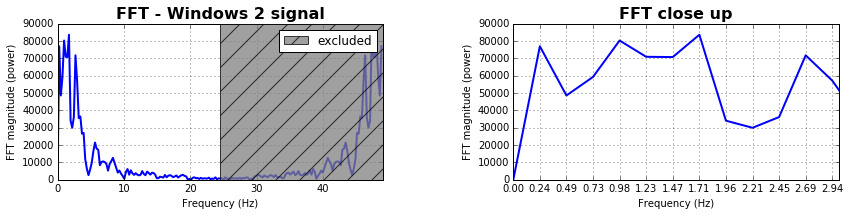

In [276]:
from matplotlib import gridspec
win_number = 2

sig = wFrames[win_number]["accX"].dropna()
N_samps = len(sig)
time_interval = 3#secs
Fs = len(sig)/time_interval           # the range of frequency to look for.
N_fft = 200                           # Number of bins (chooses granularity)
T = 1./Fs                             #the period, the sample time, the time after which each data come.
#t  = np.linspace(0,N_samps*T,N_samps) # N_samps*T (#samples x sample period) is the signal time.

mean_sig = np.ones_like(sig)*mean(sig)
# remove mean of the signal, for better results.
sig = sig - mean_sig

freqsig = fft.fft(sig,n=N_fft) 
# ATTENTION: if the ratio Fs/N_fft is equal to 1, set the start of np.arange to 1, otherwise, to zero.
freq_axis = np.arange(0,Fs,Fs/N_fft)

fig = plt.figure(figsize=[14,7])
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplots_adjust(hspace=0.5, wspace= 0.4)

##### Plot the fft #####
ax = plt.subplot(221)
pt, = ax.plot(freq_axis,np.abs(freqsig), lw=2.0, c='b')
p = plt.Rectangle((Fs/2, 0), Fs/2, ax.get_ylim()[1], facecolor="grey", fill=True, alpha=0.75, hatch="/", zorder=3)
ax.add_patch(p)
ax.set_xlim((ax.get_xlim()[0],Fs))
ax.set_title('FFT - Windows {} signal'.format(win_number), fontsize= 16, fontweight="bold")
ax.set_ylabel('FFT magnitude (power)')
ax.set_xlabel('Frequency (Hz)')
plt.legend((p,), ('excluded',))
ax.grid()

##### Close up on the graph of fft#######
# This is the same histogram above, but truncated at the max frequence + an offset. 
offset = 1    # just to help the visualization. Nothing important.
ax2 = fig.add_subplot(222)
ax2.plot(freq_axis,np.abs(freqsig), lw=2.0, c='b')
#plt.yscale('log')
ax2.set_xticks(freq_axis)
ax2.set_xlim(0,int(Fs/24)+offset)
ax2.set_title('FFT close up', fontsize= 16, fontweight="bold")
ax2.set_ylabel('FFT magnitude (power)')
ax2.set_xlabel('Frequency (Hz)')
ax2.hold(True)
ax2.grid()

print maxInds(sig,200, filterMean= True)
print meanFreq(sig,200, filterMean= True)


### 

Let's see how the metafeatures differ on all windows of the file:

In [ ]:
mean_all = []
std_all = []
max_all = []
min_all = []
mad_all = []
sma_all = []
iqr_all = []

for w in wFrames:
    mean_all.append(mean(w).to_dict())
    std_all.append(std(w).to_dict())
    max_all.append(max_value(w).to_dict())
    min_all.append(min_value(w).to_dict())
    mad_all.append(mad(w).to_dict())
    sma_all.append(sma(w).to_dict())
    iqr_all.append(iqr(w).to_dict())

df = pd.DataFrame.from_records([mean_all, std_all, max_all, min_all, mad_all, sma_all, iqr_all])
print df